In [94]:
pip install -q git+https://github.com/cpgoodri/jax_transformations3d.git

Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2

import jax
from jax import jit, vmap
from functools import partial
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax_transformations3d as jts
import colorsys
import math
from tqdm.auto import tqdm, trange

from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
@partial(vmap, in_axes=(None, None, 0, 0), out_axes=-1)
def ray_dist_to_intersect(ray_origin, ray_dir, sphere_center, sphere_radius):
    # ray_dir should be normalized
    offset_ray_origin = ray_origin-sphere_center
    a = jnp.dot(ray_dir, ray_dir)
    b = 2*jnp.dot(offset_ray_origin, ray_dir)
    c = jnp.dot(offset_ray_origin, offset_ray_origin) - sphere_radius**2

    discriminant = b**2 - 4*a*c

    dist = (-b - jnp.sqrt(discriminant)) / (2*a)

    # sphere was hit if (discriminant >= 0) & (dist >= 0)
    # if discriminant < 0, then dist is nan already, if dist < 0, then set dist to nan
    dist = jnp.where(dist < 0, jnp.nan, dist)

    return dist

def ray_trace_batch_spheres(ray_origin, ray_dir, sphere_center, sphere_radius):
    dist = ray_dist_to_intersect(ray_origin, ray_dir, sphere_center, sphere_radius)
    closest_hit = jnp.nanargmin(dist)
    dist = dist[closest_hit]

    return dist, closest_hit

@jit
@partial(vmap, in_axes=(1, 1, 1, None, None, None, None, None, None))
@partial(vmap, in_axes=(0, 0, 0, None, None, None, None, None, None))
def ray_trace(ray_origin, ray_dir, key, sphere_center, sphere_radius, mat_color, em_color, em_strength, mat):
    inc_light = jnp.zeros((3,))
    ray_color = jnp.ones((3,))

    for i in range(7):
        dist, closest_hit = ray_trace_batch_spheres(ray_origin, ray_dir, sphere_center, sphere_radius)

        did_hit = ~jnp.isnan(dist) # or: closest_hit != -1

        hit_point = ray_origin + ray_dir*dist
        normal = hit_point - sphere_center[closest_hit]
        normal = normal / jnp.linalg.norm(normal)

        emitted_light = em_color[closest_hit]*em_strength[closest_hit]
        light_strength = jnp.dot(normal, -ray_dir)
        light_strength = jnp.where(jnp.isnan(light_strength), 0, light_strength)
        inc_light += did_hit*(emitted_light * ray_color)
        # *light_strength*2
        ray_color = did_hit*ray_color*mat_color[closest_hit]*light_strength*2 + (~did_hit)*ray_color 
        
        key, subkey = jax.random.split(key, 2)
        random_dir = jax.random.normal(subkey, (3,))
        random_dir = random_dir / jnp.linalg.norm(random_dir)
        diffuse_reflect = random_dir*jnp.sign(jnp.dot(random_dir, normal))
        diffuse_reflect = diffuse_reflect / jnp.linalg.norm(diffuse_reflect)

        specular_reflect = ray_dir-2 * jnp.dot(ray_dir, normal) * normal         # maybe should be -raydir too?
        specular_reflect = specular_reflect / jnp.linalg.norm(specular_reflect)

        alpha = mat[closest_hit]
        reflect_dir = alpha*diffuse_reflect + (1-alpha)*specular_reflect

        ray_origin = hit_point
        ray_dir = reflect_dir

    return inc_light

In [22]:
base_res = 512
x_persp, y_persp = 1.5, 1
res_x, res_y = int(base_res*x_persp), int(base_res*y_persp)
camera_persp = 1.2

dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])


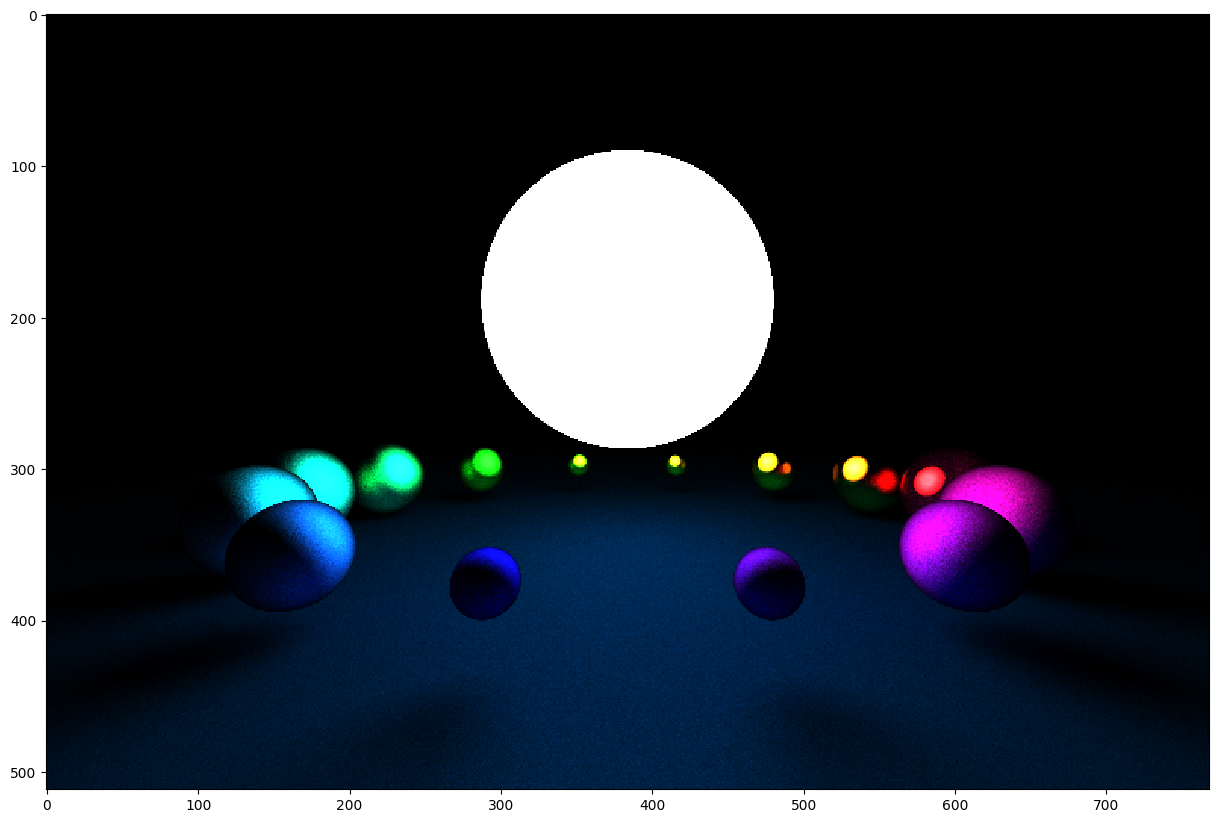

In [35]:

spheres = [
    {'pos': [10+math.sin(l*2*math.pi)*5, math.cos(l*2*math.pi)*5*1.4, 2], 'radius': 0.2+0.8*abs(math.sin(l*2*math.pi+math.pi/2)), 'mat_color': colorsys.hls_to_rgb(l*(1-1/15), 0.5, 0.9), 'em_color': [0, 0, 0], 'em_strength': 0, 'mat': 0.2+0.8*l}
    for l in jnp.linspace(0, 1, 15)
] + [

    {'pos': [20, 0, 40003], 'radius': 40000, 'mat_color': [0, 0.2, 0.4], 'em_color': [0, 0, 0],'em_strength': 0, 'mat': 1},

    {'pos': [10, 0, -2], 'radius': 3, 'mat_color': [0, 0, 0], 'em_color': [1, 1, 1], 'em_strength': 1, 'mat': 0},
]

sphere_pos, sphere_radius, mat_color, em_color, em_strength, mat = stack_dict_list(spheres)


key = jax.random.PRNGKey(0)
result_img = jnp.zeros((res_y, res_x, 3))

k = 1000
for i in trange(k):
    key, subkey = jax.random.split(key, 2)
    x_offset, y_offset = (jax.random.uniform(subkey, (2,))-0.5)*0.002
    ray_pos, ray_dirs = get_init(res_x, res_y, x_persp, y_persp, camera_persp, x_offset, y_offset)
    key_grid = jax.random.split(subkey, res_x*res_y).reshape((res_x, res_y, -1))
    result_img += ray_trace(ray_pos.copy(), ray_dirs.copy(), key_grid, sphere_pos, sphere_radius, mat_color, em_color, em_strength, mat)

plt.figure(figsize=(15, 15))
plt.imshow(result_img/result_img[300:].max()*12, interpolation='none')
plt.show()

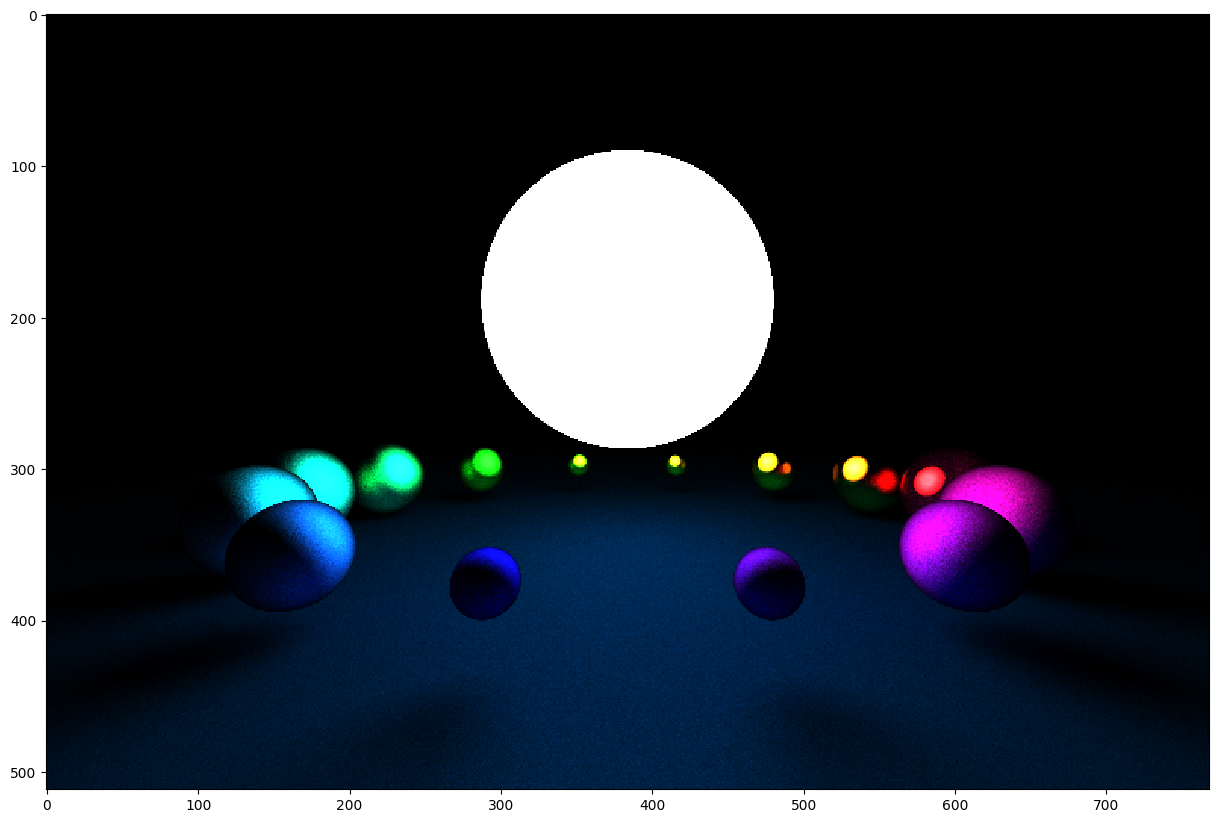

In [32]:
plt.figure(figsize=(15, 15))
plt.imshow(result_img/result_img[300:].max()*12, interpolation='none')
plt.show()

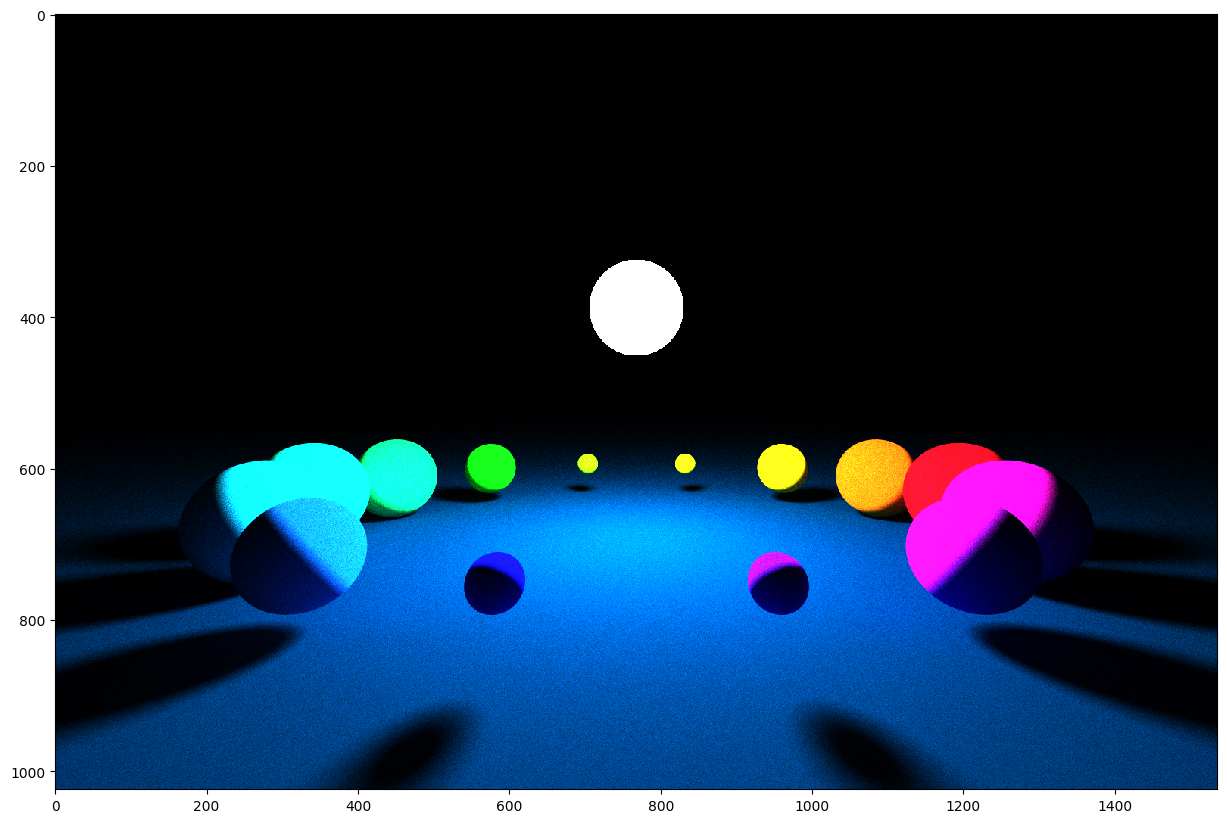

In [577]:
plt.figure(figsize=(15, 15))
plt.imshow(result_img/result_img[500:].max()*3, interpolation='none')
plt.show()

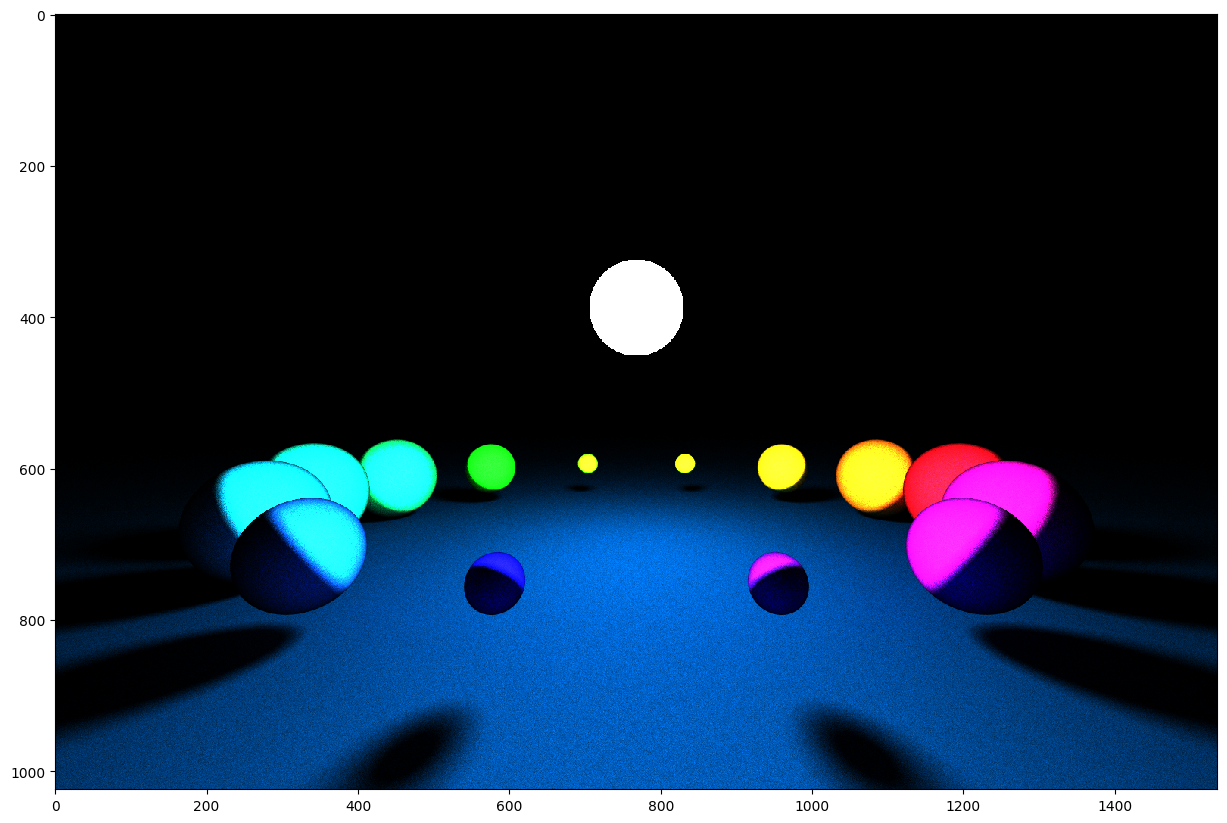

In [586]:
plt.figure(figsize=(15, 15))
plt.imshow(result_img/result_img[500:].max()*3*2, interpolation='none')
plt.show()

In [64]:
import time
t = time.time()
dist, hit_point, normal = ray_trace_iter(ray_pos, ray_dirs, sphere_pos, sphere_radius)
print(dist.sum())
print(time.time()-t)

nan
0.0009732246398925781


In [ ]:
    {'pos': [10, -5, 2], 'radius': 1, 'mat_color': [1, 0, 0], 'emission_color': [0, 0, 0], 'emission_strength': 0},
    {'pos': [10, -2.5, 2], 'radius': 1, 'mat_color': [1, 1, 0], 'emission_color': [0, 0, 0], 'emission_strength': 0},
    {'pos': [10, 5, 2], 'radius': 1, 'mat_color': [0, 1, 0], 'emission_color': [0, 0, 0], 'emission_strength': 0},
    {'pos': [10, 2.5, 2], 'radius': 1, 'mat_color': [1, 1, 1], 'emission_color': [0, 0, 0], 'emission_strength': 0},
    {'pos': [10, 0, 2], 'radius': 1, 'mat_color': [0, 0, 1], 'emission_color': [0, 0, 0], 'emission_strength': 0},


In [ ]:
"""@jit
def ray_trace_iter(ray_pos, ray_dirs, spheres, sphere_radii):
    closest_hit = jnp.nanargmin(dst, axis=-1)

    # find closest hits
    did_hit_result = jnp.take_along_axis(did_hit, indices=closest_hit[..., None], axis=-1)
    dst_result = jnp.take_along_axis(dst, indices=closest_hit[..., None], axis=-1)
    hit_point_result = jnp.take_along_axis(hit_point, indices=closest_hit[..., None, None], axis=-1).squeeze()
    normal_result = jnp.take_along_axis(normal, indices=closest_hit[..., None, None], axis=-1).squeeze()

    return did_hit_result, dst_result, hit_point_result, normal_result
"""